In [3]:
# this is importing the data set
#!pip install seaborn
#import sys
#print(sys.executable)
#!/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python -m pip install seaborn
import os
import boto3
import numpy as np
import pandas as pd
from patsy import dmatrices
from datetime import datetime
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
s3 = boto3.resource('s3')
bucket = 'ecb-hackathon-data-group10-x19s00'
path = 'economic_data/dataset_nuts3_2002-2018.csv'
data = pd.read_csv('climate_db_state-fill.csv', parse_dates = [1])
data['geo'] = data['geo'].astype('str')
data['date'] = pd.to_datetime(data['date'])
# note that the entity index comes first in order and the time dimension is second in the multi-index
data.set_index(['geo', 'date'], inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

In [4]:
# Principal Component Analysis
# Standardize the data
df = data.copy(deep=True)
vardict = {"fpanv":"Fraction of Absorbed Photosynthetically Active Radiation anomaly","lfinx":"Low river flow","smian":"soil mosture anomaly","spa01":"Standardized Precipitation Index","tpmax":"Average maximum temperature"}
substrings = ["fpanv","lfinx","smian","spa01","tpmax"]
colkeep = [col for col in df.columns for substring in substrings if substring in col]
#colkeep = colkeep + ['gva','gdp', 'pop','empl']
df = df[colkeep]
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)

# Apply PCA
pca = PCA(n_components=4)  # You can choose the number of components
principal_components = pca.fit_transform(df_standardized)
#print(pca.explained_variance_ratio_)
# Eigenvectors (Principal Components)
eigenvectors = pca.components_

# Eigenvalues 
eigenvalues = pca.explained_variance_

# Cumulative Proportion of Variance Explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Display the results
print("Variables")  
for substring in substrings:
    print(f"{substring}: {vardict[substring]}")
print()
print("Eigenvectors (Principal Components):")
for row in eigenvectors:
    print(row)
#print(eigenvectors)
print("\nEigenvalues:")
for row in eigenvalues:
    print(row)
print("\nCumulative Proportion of Variance Explained:")
print(cumulative_variance)

Variables
fpanv: Fraction of Absorbed Photosynthetically Active Radiation anomaly
lfinx: Low river flow
smian: soil mosture anomaly
spa01: Standardized Precipitation Index
tpmax: Average maximum temperature

Eigenvectors (Principal Components):
[ 0.15480477  0.52323809 -0.63158553 -0.52989996  0.15021032]
[-0.68193773  0.35118164 -0.17459765  0.18904875 -0.58771474]
[-0.58276423  0.05347311 -0.06586899  0.18413586  0.78694456]
[0.40212883 0.59339465 0.03545283 0.68926469 0.09915887]

Eigenvalues:
1.7609846267099727
1.127636392080557
0.9076743960439244
0.7465938451057873

Cumulative Proportion of Variance Explained:
[0.35219416 0.57771966 0.75925311 0.90857071]


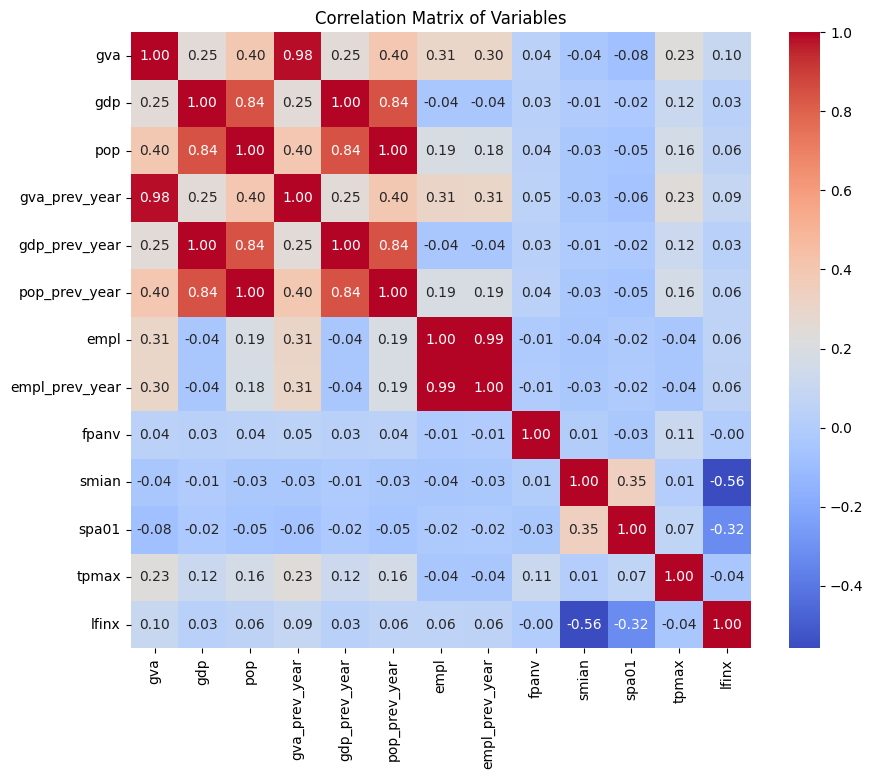

In [6]:
# show the correlation matrix
# Standardize the data
df = data.copy(deep=True)
vardict = {"fpanv":"Fraction of Absorbed Photosynthetically Active Radiation anomaly","lfinx":"Low river flow","smian":"soil mosture anomaly","spa01":"Standardized Precipitation Index","tpmax":"Average maximum temperature"}
substrings = ["fpanv","lfinx","smian","spa01","tpmax"]
colkeep = [col for col in df.columns for substring in substrings if substring in col]
df.reset_index(inplace=True)
df = df[colkeep]
df.columns = [col.split('_')[0] for col in df.columns]
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)
# Convert the standardized data back to a DataFrame
df_standardized = pd.DataFrame(df_standardized, columns=df.columns)
df = data.copy(deep=True)
df.reset_index(inplace=True)
df_standardized['date'] = df['date']
df_standardized['geo'] = df['geo']
# now I want to keep sometimes the min, sometimes the max for each year
df_standardized = df_standardized.groupby(['date','geo']).agg({
    'fpanv': 'min',
    'smian': 'min',
    'spa01': 'min',
    'tpmax': 'max',
    'lfinx': 'max'
})

# import gva data for agriculture
gva = pd.read_csv(filepath_or_buffer='full_agriculture_1_year_6_month_window.csv')
gva['date'] = pd.to_datetime(gva.year,format="%Y")
gva = gva[['date','geo','gva','gdp', 'pop','gva_prev_year','gdp_prev_year','pop_prev_year','empl','empl_prev_year']]
# Assuming gva is your DataFrame
# Keep 'date' and 'geo' columns aside
date_geo = gva[['date', 'geo']]

# Select columns to be standardized
columns_to_scale = gva.drop(['date', 'geo'], axis=1)

# Apply StandardScaler
scaler = StandardScaler()
gva_standardized = scaler.fit_transform(columns_to_scale)

# Convert the scaled data back to a DataFrame and concatenate with 'date' and 'geo'
gva_standardized_df = pd.DataFrame(gva_standardized, columns=columns_to_scale.columns)
gva_final = pd.concat([date_geo.reset_index(drop=True), gva_standardized_df], axis=1)

gva_standardized = pd.merge(gva_final, df_standardized, on=['date','geo'], how='left')
out_gva_panel = gva_standardized
gva_standardized = gva_standardized.drop(['date', 'geo'], axis=1)
                                        
# Compute the correlation matrix
corr_matrix = gva_standardized.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.savefig('climate_corr_full.pdf')
plt.show()

In [12]:
# PanelOLS
df = out_gva_panel.copy(deep=True)
df.set_index(['geo', 'date'], inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Create a DataFrame with independent variables
X = df[['gva_prev_year', 'gdp_prev_year',
       'fpanv', 'smian', 'spa01',
       'tpmax', 'lfinx']]
# Add a constant to the model, if desired
X = sm.add_constant(X)

# Define and fit the model
mod = PanelOLS(df.gva, X, entity_effects=True, time_effects=True)
res = mod.fit()
# Access the parameter table from the results
param_table = res.params
# Access the p-values
p_values = res.pvalues
# Filter variables with p-values less than 0.05
significant_vars = param_table[p_values < 0.05]
# Print the significant variables and their coefficients
print(significant_vars)
print(res)


gva_prev_year    0.362988
fpanv           -0.004542
Name: parameter, dtype: float64
                          PanelOLS Estimation Summary                           
Dep. Variable:                    gva   R-squared:                        0.1286
Estimator:                   PanelOLS   R-squared (Between):              0.5838
No. Observations:                8092   R-squared (Within):               0.1376
Date:                Wed, Nov 15 2023   R-squared (Overall):              0.5712
Time:                        15:31:48   Log-likelihood                    3115.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      145.81
Entities:                        1166   P-value                           0.0000
Avg Obs:                       6.9400   Distribution:                  F(7,6913)
Min Obs:                       1.0000                                           
Max Obs:                 

In [13]:
# Multicolinearity test
# Variance Inflation Factor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X is your DataFrame of independent variables with a constant added
# We will remove the constant when calculating VIF
X_vif = X.drop(['const'], axis=1, errors='ignore')

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


         Feature       VIF
0  gva_prev_year  1.068495
1  gdp_prev_year  1.055650
2          fpanv  1.007936
3          smian  1.522155
4          spa01  1.332938
5          tpmax  1.186315
6          lfinx  1.503870


In [15]:
# Condition Index test involves analyz
# singular value decomposition (SVD)
# Perform SVD
U, S, Vt = np.linalg.svd(X)

# Calculate Condition Indices for each dimension
condition_indices = np.max(S) / S

# Display the Condition Indices
for i, cond_index in enumerate(condition_indices):
    print(f"Dimension {i+1}: Condition Index = {cond_index}")
# no multicorrelation problem
# ondition index over 30 might suggest multicollinearity

Dimension 1: Condition Index = 1.0
Dimension 2: Condition Index = 1.2388100228720718
Dimension 3: Condition Index = 1.4338563378764115
Dimension 4: Condition Index = 1.6529791315550826
Dimension 5: Condition Index = 1.8173750368804276
Dimension 6: Condition Index = 2.3828277582441033
Dimension 7: Condition Index = 2.4464918630141064
Dimension 8: Condition Index = 5.083368440705117
